In [7]:
#importing libraries and packages
from collections import Counter, OrderedDict
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [8]:
# Load projects, our data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (json.dumps(projects[-305], indent=2))

{
  "id": 2106,
  "created_on": "2020-08-08 15:06:18",
  "title": "Fast NST for Videos (+ person segmentation) \ud83c\udfa5 + \u26a1\ud83d\udcbb + \ud83c\udfa8 = \u2764\ufe0f",
  "description": "Create NST videos and pick separate styles for the person in the video and for the background.",
  "tags": [
    "code",
    "tutorial",
    "video",
    "computer-vision",
    "style-transfer",
    "neural-style-transfer"
  ]
}


In [9]:
# Load tags
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tags.json"
tags = json.loads(urlopen(url).read())
tags_dict = {}
for item in tags:
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")

400 tags


In [10]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

2032 projects


,id,created_on,title,description,tags
0,1,2020-02-17 06:30:41,Machine Learning Basics,A practical set of notebooks on machine learni...,"[code, tutorial, keras, pytorch, tensorflow, d..."
1,2,2020-02-17 06:41:45,Deep Learning with Electronic Health Record (E...,A comprehensive look at recent machine learnin...,"[article, tutorial, deep-learning, health, ehr]"
2,3,2020-02-20 06:07:59,Automatic Parking Management using computer vi...,Detecting empty and parked spaces in car parki...,"[code, tutorial, video, python, machine-learni..."
3,4,2020-02-20 06:21:57,Easy street parking using region proposal netw...,Get a text on your phone whenever a nearby par...,"[code, tutorial, python, pytorch, machine-lear..."
4,5,2020-02-20 06:29:18,Deep Learning based parking management system ...,Fastai provides easy to use wrappers to quickl...,"[code, tutorial, fastai, deep-learning, parkin..."


In [11]:
df.columns

Index(['id', 'created_on', 'title', 'description', 'tags'], dtype='object')

## Preprocessing
Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

We can combine existing input features to create new meaningful signal (helping the model learn).

In [12]:
#feature engineering
df["text"] = df.title + " " + df.description

In [13]:
df

,id,created_on,title,description,tags,text
0,1,2020-02-17 06:30:41,Machine Learning Basics,A practical set of notebooks on machine learni...,"[code, tutorial, keras, pytorch, tensorflow, d...",Machine Learning Basics A practical set of not...
1,2,2020-02-17 06:41:45,Deep Learning with Electronic Health Record (E...,A comprehensive look at recent machine learnin...,"[article, tutorial, deep-learning, health, ehr]",Deep Learning with Electronic Health Record (E...
2,3,2020-02-20 06:07:59,Automatic Parking Management using computer vi...,Detecting empty and parked spaces in car parki...,"[code, tutorial, video, python, machine-learni...",Automatic Parking Management using computer vi...
3,4,2020-02-20 06:21:57,Easy street parking using region proposal netw...,Get a text on your phone whenever a nearby par...,"[code, tutorial, python, pytorch, machine-lear...",Easy street parking using region proposal netw...
4,5,2020-02-20 06:29:18,Deep Learning based parking management system ...,Fastai provides easy to use wrappers to quickl...,"[code, tutorial, fastai, deep-learning, parkin...",Deep Learning based parking management system ...
...,...,...,...,...,...,...
2027,2434,2020-10-06 02:13:01,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,"[article, code, pytorch, library, 3d, computer...",OpenMMLab Computer Vision MMCV is a python lib...
2028,2435,2020-10-06 12:09:17,Top “Applied Data Science” Papers from ECML-PK...,Explore the innovative world of Machine Learni...,"[article, deep-learning, machine-learning, adv...",Top “Applied Data Science” Papers from ECML-PK...
2029,2436,2020-10-06 13:29:44,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,"[article, deep-learning, machine-learning, dim...",Machine Learning Methods Explained (+ Examples...
2030,2437,2020-10-06 14:53:39,Rasoee,A powerful web and mobile application that ide...,"[api, article, code, dataset, paper, research,...",Rasoee A powerful web and mobile application t...


Filter tags above a certain frequency threshold because those with fewer samples won't be adequate for training.

In [14]:
def filter(l, include=[], exclude=[]):
    """Filter a list of items based on a list of included and excluded items.
    Args:
        l (List): list of items to filter.
        include (List, optional): list of items to include. Defaults to [].
        exclude (List, optional): list of items to exclude. Defaults to [].
    Returns:
        A list of items that are included and not excluded.
    """
    if include:
        filtered = [i for i in l if i in include]
    if exclude:
        filtered = [i for i in l if i not in exclude]
    return filtered

In [15]:
# Inclusion/exclusion criteria for tags
include = list(tags_dict.keys())
exclude = ["machine-learning", "deep-learning",  "data-science",
           "neural-networks", "python", "r", "visualization", "wandb"]

In [16]:
# Filter tags for each project
df.tags = df.tags.apply(filter, include=include, exclude=exclude)
tags = Counter(itertools.chain.from_iterable(df.tags.values))

We're also going to restrict the mapping to only tags that are above a certain frequency threshold. The tags that don't have enough projects will not have enough samples to model their relationships.

In [17]:
@widgets.interact(min_tag_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_tag_freq=30):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_tag_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_tag_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(5))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-5:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(5))

interactive(children=(IntSlider(value=30, description='min_tag_freq', max=1357), Output()), _dom_classes=('wid…

In [18]:
# Filter tags that have fewer than <min_tag_freq> occurrences
min_tag_freq = 30
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if tags[tag] >= min_tag_freq)
df.tags = df.tags.apply(filter, include=list(tags_above_freq.keys()))

Remove inputs that have no remaining(not enough frequency) tags

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [20]:
df.tags

0       [code, tutorial, keras, pytorch, tensorflow, n...
1                             [article, tutorial, health]
2                [code, tutorial, video, computer-vision]
3              [code, tutorial, pytorch, computer-vision]
4                                        [code, tutorial]
                              ...                        
2027    [article, code, pytorch, library, computer-vis...
2028                                            [article]
2029    [article, reinforcement-learning, unsupervised...
2030    [article, code, dataset, paper, research, pyto...
2031                                            [article]
Name: tags, Length: 2032, dtype: object

In [21]:
# Remove projects with no more remaining relevant tags
df = df[df.tags.map(len) > 0]
print (f"{len(df)} projects")

2026 projects


Since we are dealing with text data, we can apply some of the common preparation processes

In [22]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def preprocess(text, lower=True, stem=False, 
               filters="[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]", 
               stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub(filters, r"", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Stemming
    if stem:
        text = " ".join([porter.stem(word) for word in text.split(' ')])

    return text

In [24]:

@widgets.interact(lower=True, stem=False)
def display_preprocessed_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    preprocessed_text = preprocess(text=text, lower=lower, stem=stem)
    print (preprocessed_text)  

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [25]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(preprocess, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Machine Learning Basics A practical set of notebooks on machine learning basics, implemented in both TF2.0 + Keras and PyTorch.
machine learning basics practical set notebooks machine learning basics implemented tf2 0 keras pytorch


/tmp/ipykernel_137186/4083375544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.text = df.text.apply(preprocess, lower=True, stem=False)


## Exploratory Data Analysis (EDA)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore")

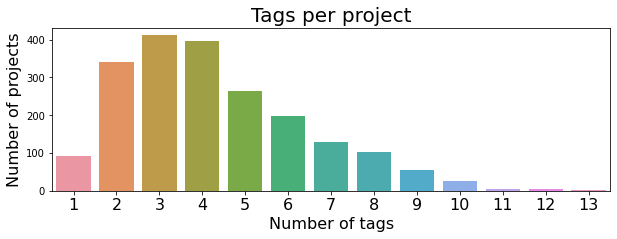

In [27]:
# Number of tags per project
num_tags_per_project = [len(tags) for tags in df.tags]
num_tags, num_projects = zip(*Counter(num_tags_per_project).items())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(num_tags), list(num_projects))
plt.title("Tags per project", fontsize=20)
plt.xlabel("Number of tags", fontsize=16)
ax.set_xticklabels(range(1, len(num_tags)+1), rotation=0, fontsize=16)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [28]:
df.tags.values

array([list(['code', 'tutorial', 'keras', 'pytorch', 'tensorflow', 'natural-language-processing']),
       list(['article', 'tutorial', 'health']),
       list(['code', 'tutorial', 'video', 'computer-vision']), ...,
       list(['article', 'reinforcement-learning', 'unsupervised-learning']),
       list(['article', 'code', 'dataset', 'paper', 'research', 'pytorch', 'computer-vision', 'demo']),
       list(['article'])], dtype=object)

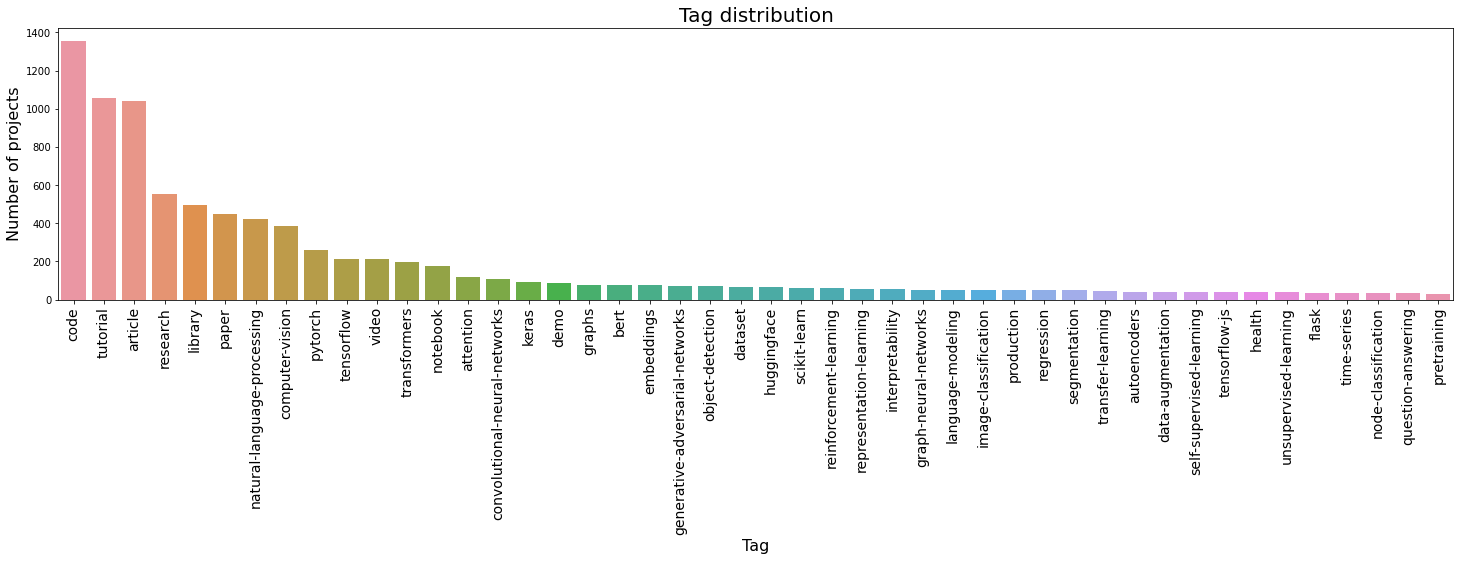

In [29]:
# Distribution of tags
all_tags = list(itertools.chain.from_iterable(df.tags.values))
tags, tag_counts = zip(*Counter(all_tags).most_common())
plt.figure(figsize=(25, 5))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [30]:

@widgets.interact(tag=list(tags))
def display_word_cloud(tag="pytorch"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tags.apply(lambda tags: tag in tags)]
    text = subset.text.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=8, options=('code', 'tutorial', 'article', 'research',…

# Label encoding

In [31]:
import numpy as np
import random

In [32]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [33]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [34]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [35]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [36]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [37]:
label_encoder.class_to_index

{'article': 0,
 'attention': 1,
 'autoencoders': 2,
 'bert': 3,
 'code': 4,
 'computer-vision': 5,
 'convolutional-neural-networks': 6,
 'data-augmentation': 7,
 'dataset': 8,
 'demo': 9,
 'embeddings': 10,
 'flask': 11,
 'generative-adversarial-networks': 12,
 'graph-neural-networks': 13,
 'graphs': 14,
 'health': 15,
 'huggingface': 16,
 'image-classification': 17,
 'interpretability': 18,
 'keras': 19,
 'language-modeling': 20,
 'library': 21,
 'natural-language-processing': 22,
 'node-classification': 23,
 'notebook': 24,
 'object-detection': 25,
 'paper': 26,
 'pretraining': 27,
 'production': 28,
 'pytorch': 29,
 'question-answering': 30,
 'regression': 31,
 'reinforcement-learning': 32,
 'representation-learning': 33,
 'research': 34,
 'scikit-learn': 35,
 'segmentation': 36,
 'self-supervised-learning': 37,
 'tensorflow': 38,
 'tensorflow-js': 39,
 'time-series': 40,
 'transfer-learning': 41,
 'transformers': 42,
 'tutorial': 43,
 'unsupervised-learning': 44,
 'video': 45}

In [38]:
# Sample
label_encoder.encode([["attention", "data-augmentation"]])

array([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [39]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(2026, 46)


## Splitting

You need to clean your data first before splitting, at least for the features that splitting depends on. So the process is more like: preprocessing (global, cleaning) → splitting → preprocessing (local, transformations). We're splitting using the tag labels which have already been inspected and cleaned during EDA.

# *Naive split*

In [40]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [41]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

For simple multiclass classification, you can specify how to stratify the split by adding the stratify keyword argument. But our task is multilabel classification, so we'll need to use other techniques to create even splits.

In [42]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)

In [43]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 1418 (0.70)
remaining: 608 (0.30)


In [44]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [45]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 1418 (0.70)
val: 304 (0.15)
test: 304 (0.15)


In [46]:
# Get counts for each class
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [47]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(34,)","(14,)","(43,)","(4,)","(33,)","(23,)","(26,)","(10,)","(0,)","(8,)",...,"(41,)","(16,)","(19,)","(30,)","(39,)","(28,)","(36,)","(25,)","(11,)","(37,)"
train,401,62,750,940,39,26,330,53,748,41,...,35,47,57,26,27,42,32,48,23,22
val,75,9,160,208,7,5,60,10,139,10,...,3,6,19,4,3,5,8,9,6,7
test,75,7,149,209,11,2,58,12,153,13,...,8,11,17,2,10,4,8,12,5,11


It's hard to compare these because our train and test proportions are different. Let's see what the distribution looks like once we balance it out. What do we need to multiply our test ratio by so that we have the same amount as our train ratio?

In [48]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [49]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,"(34,)","(14,)","(43,)","(4,)","(33,)","(23,)","(26,)","(10,)","(0,)","(8,)",...,"(41,)","(16,)","(19,)","(30,)","(39,)","(28,)","(36,)","(25,)","(11,)","(37,)"
train,401,62,750,940,39,26,330,53,748,41,...,35,47,57,26,27,42,32,48,23,22
val,350,42,746,970,32,23,280,46,648,46,...,14,28,88,18,14,23,37,42,28,32
test,350,32,695,975,51,9,270,56,714,60,...,37,51,79,9,46,18,37,56,23,51


We can see how much deviance there is in our naive data splits by computing the standard deviation of each split's class counts from the mean (ideal split).



In [50]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

12.011245611960659

Some of these distributions are not great. Let's try and balance this out a bit better.

# Stratified split

Now we'll apply iterative stratification via the skmultilearn library, which essentially splits each input into subsets (where each label is considered individually) and then it distributes the samples starting with fewest "positive" samples and working up to the inputs that have the most labels

In [51]:
from skmultilearn.model_selection import IterativeStratification

In [52]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which 
    'maintains balanced representation with respect 
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [53]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [54]:
# Binarize y
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.encode(y)

In [55]:
# Split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [56]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 1407 (0.69)
val: 314 (0.15)
test: 305 (0.15)


In [57]:
# Get counts for each class
counts = {}
counts["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [58]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [59]:
# View distributions
dist_df1=pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
         }).T.fillna(0)


In [60]:
dist_df1

,"(34,)","(14,)","(4,)","(26,)","(10,)","(13,)","(21,)","(42,)","(16,)","(22,)",...,"(9,)","(33,)","(36,)","(6,)","(35,)","(44,)","(27,)","(39,)","(37,)","(30,)"
train,386,53,950,314,52,36,347,140,45,290,...,57,36,39,74,46,28,23,30,25,25
val,387,60,947,326,42,51,382,135,46,340,...,74,42,18,74,37,18,23,18,42,23
test,382,56,952,298,65,18,312,126,42,284,...,74,56,23,74,28,32,9,28,28,9


In [61]:
# Standard deviation
np.mean(np.std(dist_df1.to_numpy(), axis=0))

8.28234845550322

Iterative stratification essentially creates splits while "trying to maintain balanced representation with respect to order-th label combinations". We used to an order=1 for our iterative split which means we cared about providing representative distribution of each tag across the splits. But we can account for higher-order label relationships as well where we may care about the distribution of label combinations.

In [62]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})
train_df.head()

,text,tags
0,message passing query embedding mpqe model ans...,"[code, embeddings, graph-neural-networks, grap..."
1,adapterhub framework adapting transformers hug...,"[code, huggingface, library, natural-language-..."
2,leveraging temporal context object detection o...,"[article, computer-vision, object-detection, p..."
3,fasthugs sequence classification transformers ...,"[article, code, huggingface, library, natural-..."
4,seeing theory visual introduction probability ...,"[code, library]"


# Augmentation
We'll often want to increase the size and diversity of our training data split through data augmentation. It involves using the existing samples to generate synthetic, yet realistic, examples.

In [63]:
!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.7 -q

In [64]:
import nlpaug.augmenter.word as naw

In [65]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [66]:
text = "Conditional image generation using Variational Autoencoders and GANs."

In [67]:
# Substitutions
augmented_text = substitution.augment(text)
print (augmented_text)

calculating spatial resolution using variational matrices and gans.


Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them. Let's try insertion...

In [68]:
# Insertions
augmented_text = insertion.augment(text)
print (augmented_text)

gnu conditional orthogonal image generation works using dynamic variational autoencoders and gans.


A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. Maybe instead of substituting or inserting new tokens, let's try simply swapping machine learning related keywords with their aliases from our auxiliary data. We'll use Snorkel's transformation functions to easily achieve this.

In [69]:
import inflect
from snorkel.augmentation import transformation_function
inflect = inflect.engine()

In [70]:
# Inflect
print (inflect.singular_noun("graphs"))
print (inflect.singular_noun("graph"))
print (inflect.plural_noun("graph"))
print (inflect.plural_noun("graphs"))

graph
False
graphs
graphss


In [71]:
def replace_dash(x):
    return x.replace("-", " ")

In [72]:
flat_tags_dict = {}
for tag, info in tags_dict.items():
    tag = tag.replace("-", " ")
    aliases = list(map(replace_dash, info["aliases"]))
    if len(aliases):
        flat_tags_dict[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flat_tags_dict[alias] = _aliases

In [73]:
# Tags that could be singular or plural
can_be_singular = [
    'animations',
    'cartoons',
    'autoencoders',
    'conditional random fields',
    'convolutional neural networks',
    'databases',
    'deep q networks',
    'gated recurrent units',
    'gaussian processes',
    'generative adversarial networks',
    'graph convolutional networks',
    'graph neural networks',
    'k nearest neighbors',
    'learning rates',
    'multilayer perceptrons',
    'outliers',
    'pos',
    'quasi recurrent neural networks',
    'recommendation systems',
    'recurrent neural networks',
    'streaming data',
    'data streams',
    'support vector machines',
    'variational autoencoders']
can_be_plural = [
    'annotation',
    'data annotation',
    'continuous integration',
    'continuous deployment',
    'crf',
    'conversational ai',
    'chatbot',
    'cnn',
    'db',
    'dqn',
    'expectation maximization',
    'fine tuning',
    'finetuning',
    'finetune',
    'gru',
    'gan',
    'gcn',
    'gnn',
    'hyperparameter optimization',
    'hyperparameter tuning',
    'image generation',
    'inference',
    'prediction',
    'knn',
    'knowledge base',
    'language modeling',
    'latent dirichlet allocation',
    'lstm',
    'machine translation',
    'model compression',
    'compression',
    'perceptron',
    'mlp',
    'optical character recognition',
    'outlier detection',
    'pos tagging',
    'pca',
    'qrnn',
    'rnn',
    'segmentation',
    'image segmentation',
    'spatial temporal cnn',
    'data streaming',
    'svm',
    'tabular',
    'temporal cnn',
    'tcnn',
    'vae',
    'vqa',
    'visualization',
    'data visualization']

In [74]:
# Add to flattened dict
for tag in can_be_singular:
    flat_tags_dict[inflect.singular_noun(tag)] = flat_tags_dict[tag]
for tag in can_be_plural:
    flat_tags_dict[inflect.plural_noun(tag)] = flat_tags_dict[tag]

In [75]:
# Doesn't perfectly match (ex. singlar tag to singlar alias)
# But good enough for data augmentation for char-level tokenization
# Could've also used stemming before swapping aliases
print (flat_tags_dict["gan"])
print (flat_tags_dict["gans"])
print (flat_tags_dict["generative adversarial network"])
print (flat_tags_dict["generative adversarial networks"])

['generative adversarial networks']
['generative adversarial networks']
['gan']
['gan']


In [76]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [77]:
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [78]:

# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [79]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 

    # Find all matches
    matches = []
    for i, tag in enumerate(flat_tags_dict):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flat_tags_dict[tag])}{x.text[match.end():]}"
    return x


In [80]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(preprocess, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey rl nlp tasks
survey rl nlp tasks


In [81]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(preprocess, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate vision apply jobs using nlp
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


Now we'll define a augmentation policy to apply our transformation functions with certain rules (how many samples to generate, whether to keep the original data point, etc.)

In [82]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [83]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 1407/1407 [00:13<00:00, 102.75it/s]


,text,tags
0,message passing query embedding mpqe model ans...,"[code, embeddings, graph-neural-networks, grap..."
1,adapterhub framework adapting transformers hug...,"[code, huggingface, library, natural-language-..."
2,leveraging temporal context object detection o...,"[article, computer-vision, object-detection, p..."
3,fasthugs sequence classification transformers ...,"[article, code, huggingface, library, natural-..."
4,seeing theory visual introduction probability ...,"[code, library]"


In [84]:
len(train_df), len(train_df_augmented)

(1407, 2676)

For now, we'll skip the data augmentation because it's quite fickle and empirically it doesn't improvement performance much. But we can see how this can be very effective once we can control what type of vocabulary to augment on and what exactly to augment with.

Regardless of what method we use, it's important to validate that we're not just augmenting for the sake of augmentation. We can do this by executing any existing data validation tests and even creating specific tests to apply on augmented data.

# 📈  Modeling
We'll begin modeling by starting with the simplest baseline and slowly adding complexity.

In [85]:
from sklearn.metrics import precision_recall_fscore_support
import torch

In [86]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [87]:
def get_data_splits(df, train_size=0.7):
    """"""
    # Get data
    X = df.text.to_numpy()
    y = df.tags

    # Binarize y
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.encode(y)

    # Split
    X_train, X_, y_train, y_ = iterative_train_test_split(
        X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = iterative_train_test_split(
        X_, y_, train_size=0.5)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [88]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step"""
        #set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader, tolerance=1e-5):
        best_val_loss = np.inf
        for epoch in range (num_epochs):
            #steps
            train_loss = self.train_step(train_dataloader)
            val_loss,_,_ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss - tolerance:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience #reset patience

            else:
                _patience -= 1
            if not patience: #0
                print("Stopping early!")
                break
            # logging
            print(
                f"Epoch: {epoch+1} |  "
                f"train Loss: {train_loss:.5f} |  "
                f"val Loss: {val_loss:.5f} |  "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model


                  

# Random

Motivation: We want to know what random (chance) performance looks like. All of our subsequent baselines should perform better than this.

In [89]:
# Set seeeds
set_seeds()

In [90]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True, stem=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1407,), y_train: (1407, 46)
X_val: (305,), y_val: (305, 46)
X_test: (314,), y_test: (314, 46)


In [91]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=46)>
['article', 'attention', 'autoencoders', 'bert', 'code', 'computer-vision', 'convolutional-neural-networks', 'data-augmentation', 'dataset', 'demo', 'embeddings', 'flask', 'generative-adversarial-networks', 'graph-neural-networks', 'graphs', 'health', 'huggingface', 'image-classification', 'interpretability', 'keras', 'language-modeling', 'library', 'natural-language-processing', 'node-classification', 'notebook', 'object-detection', 'paper', 'pretraining', 'production', 'pytorch', 'question-answering', 'regression', 'reinforcement-learning', 'representation-learning', 'research', 'scikit-learn', 'segmentation', 'self-supervised-learning', 'tensorflow', 'tensorflow-js', 'time-series', 'transfer-learning', 'transformers', 'tutorial', 'unsupervised-learning', 'video']


In [92]:

# Generate random predictions
y_pred = np.random.randint(low=0, high=2, size=(len(y_test), len(label_encoder.classes)))
print (y_pred.shape)
print (y_pred[0:5])

(314, 46)
[[0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1
  0 0 0 1 1 1 0 1 1 0]
 [0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1
  0 0 0 0 1 1 0 1 1 0]
 [0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1
  1 0 0 0 1 1 0 1 0 0]
 [0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1
  1 1 0 1 0 1 0 0 1 0]
 [1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1
  1 0 0 1 0 1 0 0 0 1]]


In [93]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.3002797370051692,
  "recall": 0.49768875192604006,
  "f1": 0.32732704489715536
}


We made the assumption that there is an equal probability for whether an input has a tag or not but this isn't true. Let's use the train split to figure out what the true probability is

In [94]:

# Percentage of 1s (tag presence)
tag_p = np.sum(np.sum(y_train)) / (len(y_train) * len(label_encoder.classes))
print (tag_p)

0.09449646179042674


In [95]:
# Generate weighted random predictions
y_pred = np.random.choice(
    np.arange(0, 2), size=(len(y_test), len(label_encoder.classes)),
    p=[1-tag_p, tag_p])

In [96]:
# Validate percentage
np.sum(np.sum(y_pred)) / (len(y_pred) * len(label_encoder.classes))


0.09844918305178621

In [97]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.27672187498569706,
  "recall": 0.0970724191063174,
  "f1": 0.116619456811585
}


Limitations: We didn't use any of the signals from out inputs to affect predictions, so nothing was learned.